<a href="https://colab.research.google.com/github/AdnaneMOUZAOUI/Analyse-de-sentiments-machine-learning/blob/Reviews-Analysis/RandomForest_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importer le fichier depuis le drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import re
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCAD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [ ]:
df = pd.read_csv('data_preparee.csv', index_col=[0])
df.head()
df_save=df
df=df_save

In [ ]:
# On enlève les colonnes que l'on ne conserve pas pour la modélisation
df=df.drop(columns=['client', 'star', 'date_commande', 'date', 'pays', 'Commentaire', 'Titre', 'ngram_2', 'ngram_3', 'ngram_2_titre', 'ngram_3_titre'], axis=1)
df=df.dropna(axis=0,how='any')



# Préparation de la variable cible et des variables explicatives
y=df['star_cluster']
X=df.drop('star_cluster',1)



# Etape Centrer Réduire des variables continues


scaler = StandardScaler()



X.loc[:, variables_continues] = scaler.fit_transform(X.loc[:, variables_continues])




In [ ]:
# Séparation en un ensemble d'entrainement, et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: imblearn in c:\users\f.rouxelin\anaconda3\lib\site-packages (0.0)



Nombre de composantes retenues : 35


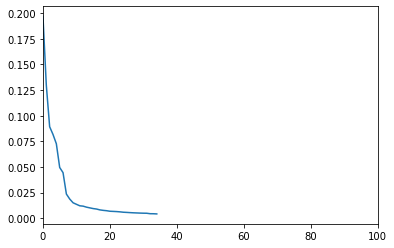

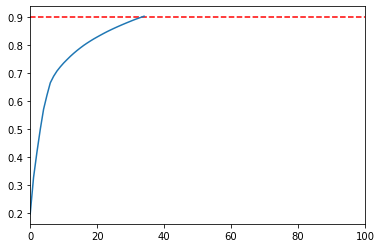

In [ ]:
# Réduction de la dimension via PCA

pca = PCA(n_components = 0.9)
pca.fit(X)
print("Nombre de composantes retenues :", pca.n_components_)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure()
plt.xlim(0,100)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,100)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());





In [ ]:
# Test algo classification 1
# Ce test se base sur les métadonnées, les compteurs et n_grams 2 et 3 des commentaires et des titres.

# RandomForest
RFC = RandomForestClassifier(n_jobs = -1)
RFC.fit(X_train_pca, y_train)
score_rfc=RFC.score(X_test_pca, y_test)
print(score_rfc)

y_pred=RFC.predict(X_test_pca)
print(classification_report(y_test, y_pred))



0.8052044169454394
              precision    recall  f1-score   support

           0       0.77      0.74      0.75     13717
           1       0.83      0.85      0.84     20062

    accuracy                           0.81     33779
   macro avg       0.80      0.79      0.80     33779
weighted avg       0.80      0.81      0.80     33779



In [ ]:
# Test over_sampling
rOs = RandomOverSampler()
X_train_pca_ovs, y_train_ovs = rOs.fit_resample(X_train_pca, y_train)
print('Classes échantillons oversampled :', dict(pd.Series(y_train_ovs).value_counts()))

# RandomForest avec oversampling
RFC = RandomForestClassifier(n_jobs = -1)
RFC.fit(X_train_pca_ovs, y_train_ovs)
score_rfc=RFC.score(X_test_pca, y_test)
print(score_rfc)

y_pred=RFC.predict(X_test_pca)
print(classification_report(y_test, y_pred))

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

confusion_matrix
# L'oversampling n'est pas très conclusif

NameError: ignored

(-1.0, 1.0)

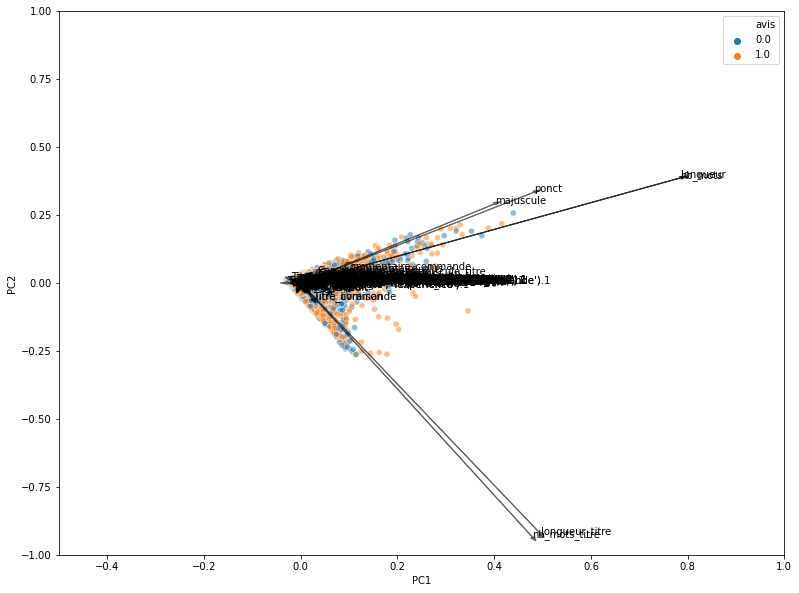

In [ ]:
n = X_train.shape[1]

coeff = pca.components_.transpose()
xs = X_train_pca[:, 0]
ys = X_train_pca[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())

principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred=RFC.predict(X_test_pca)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='avis')], axis=1)


plt.figure(figsize=(13, 10))

sns.scatterplot(x='PC1', y='PC2', hue='avis', data=finalDF, alpha=0.5)

for i in range(n):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.5, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, X_train.columns[i], color='k')

plt.xlim(-0.5, 1)
plt.ylim(-1, 1)